In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tensorflow.keras.utils import to_categorical

dataset = """C:\\Users\\divij\\Desktop\\ml\\project\\dataset"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\divij\AppData\Local\Temp\ipykernel_27912\498880202.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


This Project is Divided Into 3 section Data Cleaning and Pre Processing

Section 1 : Data PreProcessing 

Check if GPU is Available

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

if device.type == "cuda":
    gpu_index = 0
    print("Selected GPU:", torch.cuda.get_device_name(gpu_index))
    torch.cuda.set_device(gpu_index)



Selected device: cuda
Selected GPU: NVIDIA GeForce RTX 4050 Laptop GPU


SECTION 1.1 : Seting Up DataFrames

Train Data

In [3]:
import os
import pandas as pd

paths = []
labels = []
for bird_type in os.listdir("C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\train"):
    cur_path = os.path.join("C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\train",bird_type)
    path_data = os.listdir(cur_path)
    paths.extend([os.path.join(cur_path,img) for img in path_data])
    labels.extend([bird_type]*len(path_data))

df_train = pd.DataFrame({"path":paths,"label":labels})

print("Shape of df_train is: ", df_train.shape)
df_train.head(10)

Shape of df_train is:  (84635, 2)


,path,label
0,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER
1,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER
2,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER
3,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER
4,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER
5,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER
6,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER
7,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER
8,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER
9,C:\Users\divij\Desktop\ml\project\dataset\trai...,ABBOTTS BABBLER


Validation DataFrame

In [4]:
paths = []
labels = []
for bird_type in os.listdir("C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\valid"):
    cur_path = os.path.join("C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\valid",bird_type)
    path_data = os.listdir(cur_path)
    paths.extend([os.path.join(cur_path,img) for img in path_data])
    labels.extend([bird_type]*len(path_data))

df_valid = pd.DataFrame({"path":paths,"label":labels})

print("Shape of df_valid is: ", df_valid.shape)
df_valid.head(10)

Shape of df_valid is:  (2625, 2)


,path,label
0,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BABBLER
1,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BABBLER
2,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BABBLER
3,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BABBLER
4,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BABBLER
5,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BOOBY
6,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BOOBY
7,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BOOBY
8,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BOOBY
9,C:\Users\divij\Desktop\ml\project\dataset\vali...,ABBOTTS BOOBY


In [5]:
paths = []
labels = []
for bird_type in os.listdir("C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\test"):
    cur_path = os.path.join("C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\test",bird_type)
    path_data = os.listdir(cur_path)
    paths.extend([os.path.join(cur_path,img) for img in path_data])
    labels.extend([bird_type]*len(path_data))

df_test = pd.DataFrame({"path":paths,"label":labels})

print("Shape of df_test is: ", df_test.shape)
df_test.head(10)

Shape of df_test is:  (2625, 2)


,path,label
0,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
1,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
2,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
3,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
4,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
5,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BOOBY
6,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BOOBY
7,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BOOBY
8,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BOOBY
9,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BOOBY


No of Species of Brids are in the Dataset

In [6]:
print("How many species of birds are there in dataset: ", df_train['label'].nunique())

How many species of birds are there in dataset:  525


No of Lables

In [7]:
df_train['label'].value_counts()

label
RUFOUS TREPE               263
HOUSE FINCH                248
OVENBIRD                   233
D-ARNAUDS BARBET           233
ASIAN GREEN BEE EATER      220
                          ... 
RED TAILED THRUSH          130
NORTHERN RED BISHOP        130
AMETHYST WOODSTAR          130
PATAGONIAN SIERRA FINCH    130
SNOWY PLOVER               130
Name: count, Length: 525, dtype: int64

Data Visualization Labels and Sample

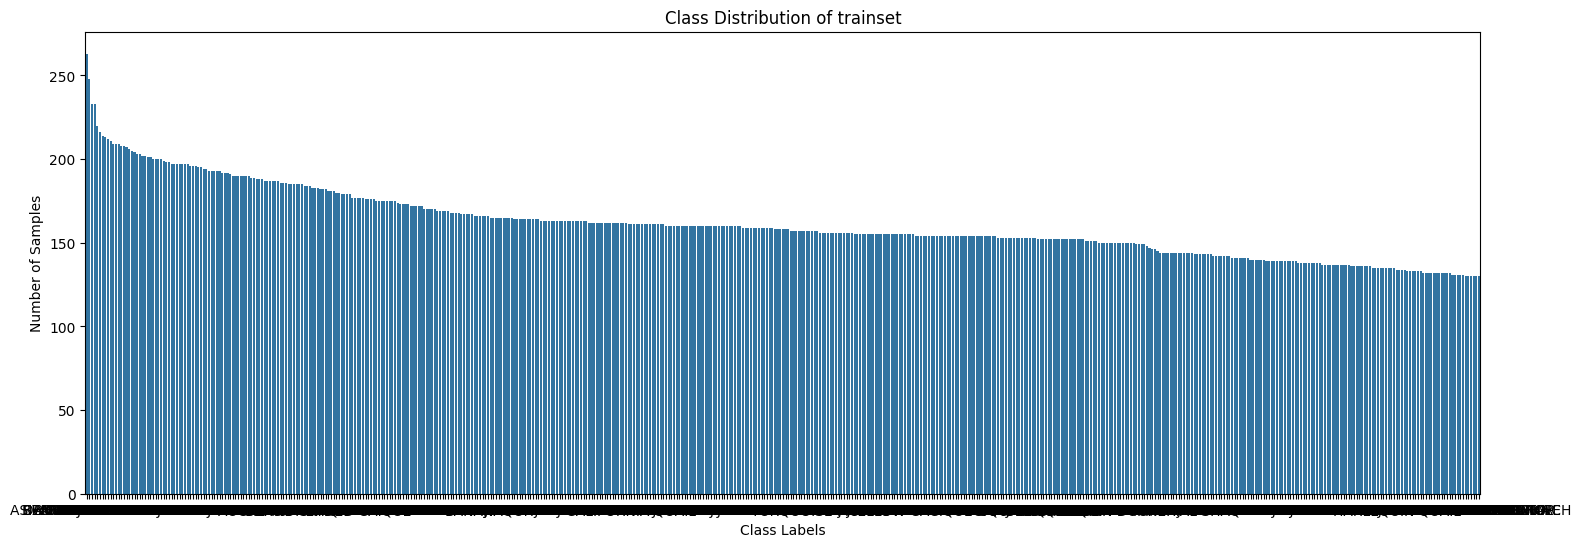

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = df_train['label']
label_counts = labels.value_counts()

plt.figure(figsize=(18, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Class Distribution of trainset')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.show()

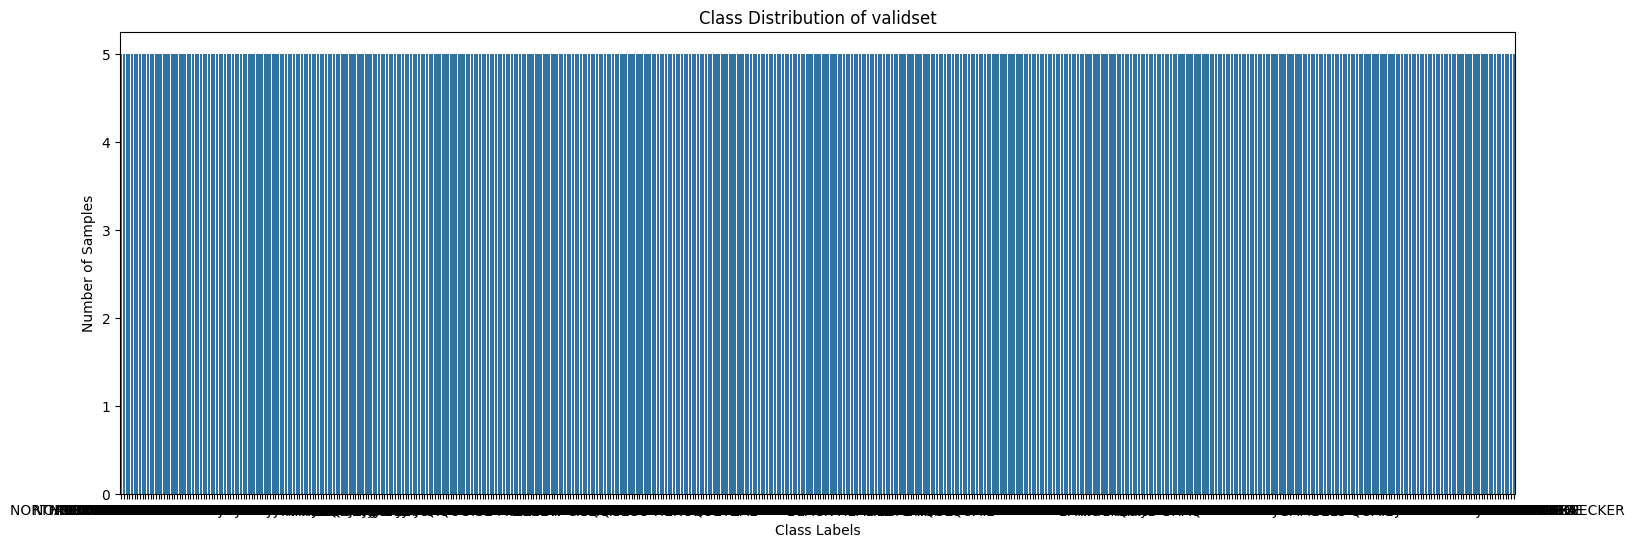

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = df_valid['label']
label_counts = labels.value_counts()

plt.figure(figsize=(18, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Class Distribution of validset')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.show()

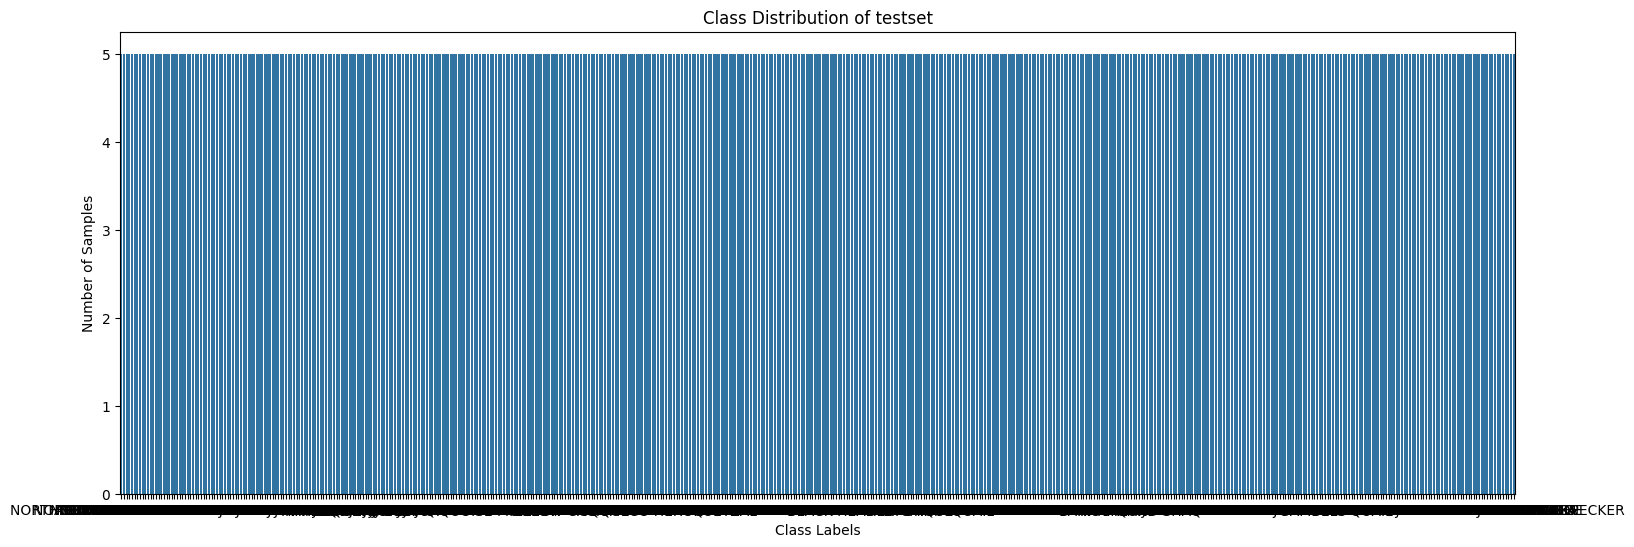

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = df_test['label']
label_counts = labels.value_counts()

plt.figure(figsize=(18, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Class Distribution of testset')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.show()

In [11]:
df_train['label'] = df_train['label'].replace('PARAKETT  AUKLET', 'PARAKETT AUKLET')
df_test['label'] = df_test['label'].replace('PARAKETT  AUKLET', 'PARAKETT AUKLET')

In [12]:
# mapping data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#df_train['label'] = le.fit_transform(df_train['label'])
#df_valid['label'] = le.transform(df_valid['label'])
#df_test['label'] = le.transform(df_test['label'])

print("Shape of df_train is: ", df_train.shape)
print("Shape of df_valid is: ", df_valid.shape)
print("Shape of df_test is: ", df_test.shape)

df_test.head(7)

Shape of df_train is:  (84635, 2)
Shape of df_valid is:  (2625, 2)
Shape of df_test is:  (2625, 2)


,path,label
0,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
1,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
2,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
3,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
4,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BABBLER
5,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BOOBY
6,C:\Users\divij\Desktop\ml\project\dataset\test...,ABBOTTS BOOBY


View Images

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
  # setting up the image directory
  target_folder = target_dir

  #read image and plotting it
  img = mpimg.imread(target_folder)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  print(f"Path : {target_folder}")
  
  return img

Image shape: (224, 224, 3)
Path : C:\Users\divij\Desktop\ml\project\dataset\test\AMERICAN GOLDFINCH\5.jpg


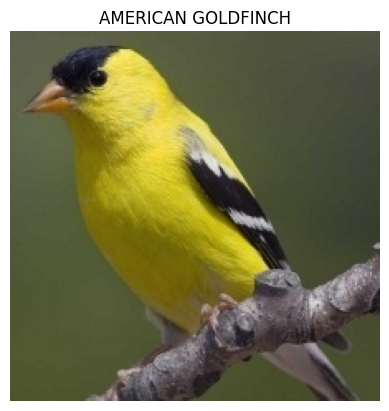

In [22]:
img = view_random_image(str(df_test['path'].values[99]), str(df_test['label'].values[99]))

Classification Model: 

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [16]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# # Define the model
# model = models.Sequential()

# model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(224,224, 3)))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.7))

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(525, activation='softmax'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
# model.add(Dense(525, activation='softmax'))
# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Display the model summary
# model.summary()


In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(525, activation='softmax'))

model.summary()

c:\Users\divij\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 525)            │       134,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,379,597 (85.37 MB)

 Trainable params: 22,379,597 (85.37 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
le = preprocessing.LabelEncoder()
from tensorflow.keras.utils import to_categorical


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_dir = "C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\train"
test_dir = "C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\test"
val_dir = "C:\\Users\\divij\\Desktop\\ml\\project\\dataset\\valid"


# data transfer from directories to batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (224,224),
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "categorical")

val_data = valid_datagen.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "categorical")

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [ ]:
steps_per_epoch = len(train_data)
validation_steps = int(0.25*len(val_data))
                       

In [20]:
model.compile(loss='categorical_crossentropy',
               optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(train_data,
           steps_per_epoch = len(train_data), epochs=5,
            batch_size=16,
            validation_data =val_data,
            validation_steps = int(0.25*len(val_data)))



Epoch 1/5


c:\Users\divij\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2645/2645 ━━━━━━━━━━━━━━━━━━━━ 938s 354ms/step - accuracy: 0.0154 - loss: 5.9795 - val_accuracy: 0.1844 - val_loss: 4.2361
Epoch 2/5


c:\Users\divij\miniconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2645/2645 ━━━━━━━━━━━━━━━━━━━━ 2s 701us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1813 - val_loss: 4.1823
Epoch 3/5
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 913s 345ms/step - accuracy: 0.1553 - loss: 4.3967 - val_accuracy: 0.3719 - val_loss: 3.1810
Epoch 4/5
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 2s 676us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 3.2342
Epoch 5/5
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 902s 341ms/step - accuracy: 0.2903 - loss: 3.4000 - val_accuracy: 0.3846 - val_loss: 2.2588


In [21]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data)
print(f'Test Accuracy: {test_acc*100:.2f}%')

83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.4402 - loss: 2.6492
Test Accuracy: 44.30%
